# Load Data

In [90]:
%load_ext autoreload
%autoreload 2
from load_prism import load_3D
from liftpose.vision_3d import XY_coord_dict, Z_coord_dict
import yaml
import logging
from imp import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# declare data parameters
par_train = {'data_dir'       : '/data/LiftPose3D/fly_prism/data_oriented/',#mac/ubuntu path
             #'data_dir'       : r"\Users\NeLy\Desktop\fly_prism/data_oriented/training_data", #windows path  
             'out_dir'        : '/data/LiftPose3D/domain_adapt_LiftPose3D_station/',
             "train_subjects" : ["001","002","003","004"],
             'test_subjects'  : ["004"],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
train, train_keypts, _ = load_3D(par["data_dir"], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load_3D( par["data_dir"], subjects=par['test_subjects'],  actions=par['actions'])

#project data to ventral view
train_2d, train_3d = XY_coord_dict(train), Z_coord_dict(train)
test_2d, test_3d  = XY_coord_dict(test), Z_coord_dict(test)
train_keypts = Z_coord_dict(train_keypts)
test_keypts = Z_coord_dict(test_keypts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [91]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'])

[main.py:242]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/domain_adapt_LiftPose3D_station/stat_2d.pth.tar.
[main.py:261]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/domain_adapt_LiftPose3D_station/stat_3d.pth.tar.
[main.py:289]:INFO:Starting training model.
[main.py:300]:DEBUG:
==================Options=================
[main.py:301]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/domain_adapt_LiftPose3D_station',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/domain_adapt_LiftPose3D_station',
    'out_dir': '/data/LiftPose3D/domain_adapt_LiftPose3D_station',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:302]:DEBUG:===================================

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.92363|: 100%|██████████| 227/227 [00:01<00:00, 146.32it/s]
Epoch 001 | LR  0.00100 | Loss Test  0.12742 | Loss Train  0.24213|: 100%|██████████| 227/227 [00:01<00:00, 147.65it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.05537 | Loss Train  0.10895|: 100%|██████████| 227/227 [00:01<00:00, 152.43it/s]
Epoch 003 | LR  0.00100 | Loss Test  0.03559 | Loss Train  0.06538|: 100%|██████████| 227/227 [00:01<00:00, 154.02it/s]
Epoch 004 | LR  0.00100 | Loss Test  0.03239 | Loss Train  0.05138|: 100%|██████████| 227/227 [00:01<00:00, 153.59it/s]
Epoch 005 | LR  0.00100 | Loss Test  0.02830 | Loss Train  0.04364|: 100%|██████████| 227/227 [00:01<00:00, 146.77it/s]
Epoch 006 | LR  0.00100 | Loss Test  0.03497 | Loss Train  0.03742|: 100%|██████████| 227/227 [00:01<00:00, 157.46it/s]
Epoch 007 | LR  0.00100 | Loss Test  0.03030 | Loss Train  0.03724|: 100%|██████████| 227/227 [00:01<00:00, 150.05it/s]
Epoch 008 | LR  0.00100 | Loss Test  0.0

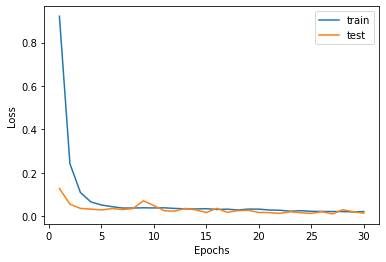

In [92]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [93]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:391]:INFO:starting testing in path: /data/LiftPose3D/domain_adapt_LiftPose3D_station/
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:56]:INFO:total params: 4.26M
[lift.py:64]:INFO:loading ckpt from '/data/LiftPose3D/domain_adapt_LiftPose3D_station/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 27 | err: 1.0419670028104635)
[lift.py:106]:INFO:Saving results: /data/LiftPose3D/domain_adapt_LiftPose3D_station/test_results.pth.tar


# Visualize Predictions

In [94]:
from liftpose.postprocess import load_test_results
test_3d_gt, test_3d_pred, good_keypts = load_test_results(par['out_dir'], prism=True)
test_3d_gt *= 2.5/400
test_3d_pred *= 2.5/400

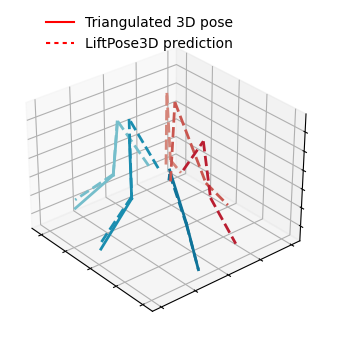

In [100]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
from liftpose.preprocess import add_roots
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=140)

t = 1000
plot_pose_3d(ax, tar=test_3d_gt[t],
            pred=test_3d_pred[t],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t][:,None],
            show_pred_always=True,
            legend=True)